### Text Selection Data Prepare

This notebook was used for data pre-processing in the text selection project.

In [1]:
import os
import multiprocessing
#import multiprocessing as mp
from multiprocessing import Process, Manager, Pool, Queue
from itertools import islice
from collections import Counter
import re
import pandas as pd
import numpy as np
import glob
import nltk
from nltk import word_tokenize
from functools import reduce
from pathlib import Path
import shutil
from kneed import KneeLocator

In [2]:
nprocs = multiprocessing.cpu_count()
print(f"Number of CPU cores: {nprocs}")

Number of CPU cores: 16


In [3]:
# language pair
lang_folder = "English"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> target language for learner
#lang_pair = "Intersect"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> native language

# adding native word to shared word
word_start = 0  # 0 native word start index
word_end = 45000  # 28 native word end index

# word all usage in twogram
word_use_num_min = 1  # word usage in selected twograms 
word_use_num_max = 2

# sentence check
twogram_sentence_check = False  # True, False
threegram_sentence_check = False
fourgram_sentence_check = False
fivegram_sentence_check = False
sixgram_sentence_check = False
sevengram_sentence_check = False
eightgram_sentence_check = False
ninegram_sentence_check = False
tengram_sentence_check = False


# n gram select
twogram_select_start = 0
twogram_select_end = 10000

threegram_select_start = 0
threegram_select_end = 10000

fourgram_select_start = 0
fourgram_select_end = 10000

fivegram_select_start = 0
fivegram_select_end = 10000

sixgram_select_start = 0
sixgram_select_end = 10000

sevengram_select_start = 0
sevengram_select_end = 10000

eightgram_select_start = 0
eightgram_select_end = 10000

ninegram_select_start = 0
ninegram_select_end = 10000

tengram_select_start = 0
tengram_select_end = 10000


# prefix suffix file
prefix_suffix = False  # True, False: True for adding prefix suffix word
native_word = True # True for adding native word

# adding output file extention
if prefix_suffix & native_word:
    file_ext = "5"
elif (not prefix_suffix) & native_word:
    file_ext = "6"
else:
    file_ext = "7"              
    
# 5 => for only native word with prefix suffix.
# 6 => for only native word without prefix suffix.

print(f"{file_ext}")

6


In [4]:
path = f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/\
Text Selection/Data/1-Text Selection Data Prepare"

Path(path).mkdir(parents=True, exist_ok=True)

In [5]:
def strip(df):
    for i in df.columns:
        new_name = i.strip()
        df.rename(columns={f"{i}":f"{new_name}"}, inplace=True)
        df[f"{new_name}"] = df[f"{new_name}"].apply(lambda x: x.strip())
    
    return df

In [6]:
def word_in_wordgroup_simple(df, source_column, target_column, word_sample_num):

    '''word_in_wordgroup(df, "word", "twogram"):
       df is dataframe, source_column and target_column are 
       dataframe column string name. source_column convert list
       values that are in target column.
    '''
    
    df_select = df[[f"{target_column}"]].dropna()
    df_result = pd.DataFrame()
    for i in df[f"{source_column}"].dropna():
        try:
            word_in_word_cluster = df_select[df_select[f"{target_column}"].str.contains(fr"(?:\s|^){i}(?:\s|$)", na=False)].head(word_sample_num)    
        except:
            pass        
        word_in_word_cluster.insert(0,f"{source_column}",i)
        df_result = pd.concat([df_result,word_in_word_cluster], axis=0)
    df_result.reset_index(drop=True, inplace=True)

    return df_result

In [7]:
df_word_all = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.lower().capitalize()}/Deployment/Data/Word/Word_Merge_Preprocess.xlsx")
df_word_all

,word,frequency
0,you,102069964
1,i,94447074
2,the,77481215
3,to,58281119
4,is,50852895
...,...,...
552149,fruitcocktail,6
552150,andthesunlightshining,6
552151,upravo,6
552152,yagawa,6


In [8]:
df_word_select = df_word_all.iloc[word_start:word_end,]

In [9]:
# Option
if prefix_suffix:
    df_word = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()}/{lang_folder.capitalize()}_{word_end}_Word_Prefix_Suffix_Custom_Result_Manuel.xlsx")
    df_word = df_word.loc[:,["word","frequency"]]
    df_word = pd.concat([df_word,df_word_select], axis=0)
    df_word.drop_duplicates(inplace=True)    
    df_word.sort_values(by="frequency", ascending=False, inplace=True)
    df_word.reset_index(drop=True, inplace=True)
else:
    df_word = df_word_select

if native_word:
    df_word
else:
    df_word = df_word.head(0)

df_word

,word,frequency
0,you,102069964
1,i,94447074
2,the,77481215
3,to,58281119
4,is,50852895
...,...,...
44995,pythons,630
44996,bubbe,630
44997,clucking,630
44998,komal,630


In [10]:
#df_word.to_excel(f"Word_Selected_{word_end}.xlsx", index=False)

In [11]:
disable_list = ["sex","seks","seksi","sexy","sexe","seksüel","sexuell","gey","gay","lezbiyen","lesbienne","eşcinsel","mastürbasyon","masturbation","erotik","érotique", \
"bikini","penis","vagina","vajina","fetish","fetiş","fetishy","erotic","erotik","sexdom","kondom","condom","dildo","fetisj","hétérosexuel","féticher","fétiche","homosexuel"\
"ereksiyon","erectie","erection","érection","homoseksüel","prezervatif","préservatif","ass","fetisch","fetiche"]

In [12]:
word_select = df_word["word"].values.tolist()
word_select_set = set(word_select)
disable_word_set = set(disable_list)

In [13]:
word_list = list(word_select_set.difference(disable_word_set))
len(word_list)

44918

##### Ngrams Selected

In [14]:
if twogram_sentence_check:
    df_twogram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Two_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_twogram_sent.rename(columns={"two_gram":"twogram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_twogram = df_twogram_sent.loc[:,["twogram","frequency"]]
    #df_twogram_select = df_twogram.iloc[twogram_start:twogram_end,]
else:
    df_twogram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Twogram_Merge.csv")  
    df_twogram = df_twogram.loc[:,["twogram","frequency"]]
    #df_twogram_select = df_twogram.iloc[twogram_start:twogram_end,]

df_twogram = df_twogram[df_twogram["frequency"] > 5]
df_twogram

,twogram,frequency
0,i am,9310563
1,do not,8095395
2,it s,7436197
3,that s,4564126
4,you re,4355237
...,...,...
4505226,hoof taps,6
4505227,benjamin wells,6
4505228,run title,6
4505229,router back,6


In [15]:
d_list2  = df_twogram.iloc[:,0].values.tolist()

resultlist2 = []
manager = multiprocessing.Manager()
resultlist2 = manager.list()

def wordgroup_with_words(d_list2):
    mergelist = []
    try:
        word = d_list2.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist2.append(d_list2)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list2) # string_word liste

result_list2 = list(resultlist2)
df_result2 = pd.DataFrame(result_list2, columns=[0])  # add columns parameter for empty result
df_result2 = df_result2.rename(columns = {0: "twogram"})
df_merge2 = pd.merge(df_result2, df_twogram, how="left", on="twogram")
df_merge_result2 = df_merge2.sort_values(by="frequency", ascending=False)
df_merge_result2.drop_duplicates(inplace=True)
df_merge_result2.reset_index(drop=True, inplace=True)
df_twogram_select = df_merge_result2
df_twogram_select

,twogram,frequency
0,i am,9310563
1,do not,8095395
2,it s,7436197
3,that s,4564126
4,you re,4355237
...,...,...
3630143,train honey,6
3630144,go blackwater,6
3630145,hammond suggested,6
3630146,jano would,6


In [16]:
twogram_frequency = df_twogram_select.iloc[:,1].sum()

In [17]:
df_twogram_select["ratio"] = round(((df_twogram_select.iloc[:,1]/twogram_frequency)*100),7)

In [18]:
df_twogram_select["cumul_ratio"] = np.cumsum(df_twogram_select["ratio"])

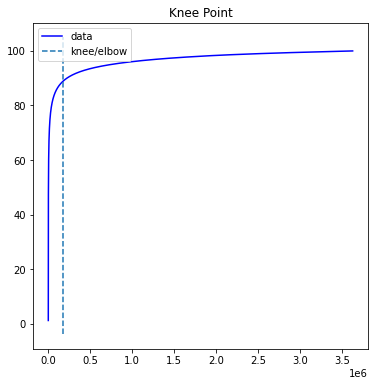

In [19]:
twogram_kneedle = KneeLocator(x=df_twogram_select.cumul_ratio.index, y=df_twogram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
twogram_kneedle.plot_knee()

In [20]:
knee_point_twogram = round(twogram_kneedle.knee_y)

In [21]:
df_twogram_knee = df_twogram_select[df_twogram_select.cumul_ratio <= knee_point_twogram]
df_twogram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_twogram_knee

<ipython-input-21-8da720a80491>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_twogram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)


,twogram,frequency
0,i am,9310563
1,do not,8095395
2,it s,7436197
3,that s,4564126
4,you re,4355237
...,...,...
179482,creepy is,203
179483,load for,203
179484,and whipped,203
179485,is oskar,203


In [22]:
df_twogram_select2 = df_twogram_select.iloc[twogram_select_start:twogram_select_end,]
df_twogram_select2

,twogram,frequency,ratio,cumul_ratio
0,i am,9310563,1.255778,1.255778
1,do not,8095395,1.091880,2.347658
2,it s,7436197,1.002970,3.350627
3,that s,4564126,0.615594,3.966221
4,you re,4355237,0.587420,4.553641
...,...,...,...,...
9995,okay sir,6936,0.000936,68.921631
9996,hurry hurry,6935,0.000935,68.922566
9997,bad as,6933,0.000935,68.923501
9998,be glad,6932,0.000935,68.924436


In [23]:
df_twogram_knee.to_csv("Twogram_Selected.csv", index=False)
df_twogram_select2.to_excel(f"Twogram_Selected_{twogram_select_end}.xlsx", index=False)

In [24]:
if threegram_sentence_check:
    df_threegram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Three_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_threegram_sent.rename(columns={"three_gram":"threegram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_threegram = df_threegram_sent.loc[:,["threegram","frequency"]]
else:
    df_threegram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Threegram_Merge.csv")  
    df_threegram = df_threegram.loc[:,["threegram","frequency"]]

df_threegram

,threegram,frequency
0,i do not,3246539
1,do not know,1606191
2,what are you,1324981
3,i am not,1120471
4,i am sorry,1103453
...,...,...
11617124,he s abby,6
11617125,if richard knows,6
11617126,he requested this,6
11617127,sound of opportunity,6


In [25]:
d_list3  = df_threegram.iloc[:,0].values.tolist()

resultlist3 = []
manager = multiprocessing.Manager()
resultlist3 = manager.list()

def wordgroup_with_words(d_list3):
    mergelist = []
    try:
        word = d_list3.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist3.append(d_list3)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list3) # string_word liste

result_list3 = list(resultlist3)
df_result3 = pd.DataFrame(result_list3, columns=[0])  # add columns parameter for empty result
df_result3 = df_result3.rename(columns = {0: "threegram"})
df_merge3 = pd.merge(df_result3, df_threegram, how="left", on="threegram")
df_merge_result3 = df_merge3.sort_values(by="frequency", ascending=False)
df_merge_result3.drop_duplicates(inplace=True)
df_merge_result3.reset_index(drop=True, inplace=True)
df_threegram_select = df_merge_result3
df_threegram_select

,threegram,frequency
0,i do not,3246539
1,do not know,1606191
2,what are you,1324981
3,i am not,1120471
4,i am sorry,1103453
...,...,...
10406366,recipe for something,6
10406367,not that irisa,6
10406368,rachel s betrayal,6
10406369,who either entered,6


In [26]:
threegram_frequency = df_threegram_select.iloc[:,1].sum()

In [27]:
df_threegram_select["ratio"] = round(((df_threegram_select.iloc[:,1]/threegram_frequency)*100),7)

In [28]:
df_threegram_select["cumul_ratio"] = np.cumsum(df_threegram_select["ratio"])

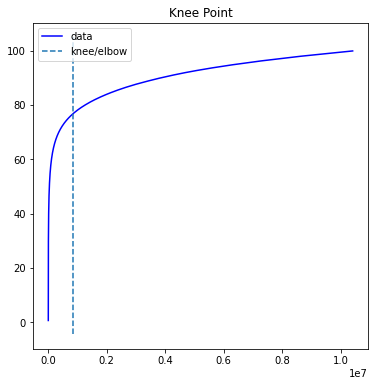

In [29]:
threegram_kneedle = KneeLocator(x=df_threegram_select.cumul_ratio.index, y=df_threegram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
threegram_kneedle.plot_knee()

In [30]:
knee_point_threegram = round(threegram_kneedle.knee_y)

In [31]:
df_threegram_knee = df_threegram_select[df_threegram_select.cumul_ratio <= knee_point_threegram]
df_threegram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_threegram_knee

<ipython-input-31-b241fb118b27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_threegram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)


,threegram,frequency
0,i do not,3246539
1,do not know,1606191
2,what are you,1324981
3,i am not,1120471
4,i am sorry,1103453
...,...,...
871213,about you vi,48
871214,bien phu we,48
871215,every night that,48
871216,moved in daylight,48


In [32]:
df_threegram_select2 = df_threegram_select.iloc[threegram_select_start:threegram_select_end,]
df_threegram_select2

,threegram,frequency,ratio,cumul_ratio
0,i do not,3246539,0.616062,0.616062
1,do not know,1606191,0.304790,0.920852
2,what are you,1324981,0.251428,1.172280
3,i am not,1120471,0.212620,1.384900
4,i am sorry,1103453,0.209391,1.594290
...,...,...,...,...
9995,you hold on,4818,0.000914,38.039522
9996,one by one,4818,0.000914,38.040436
9997,you next week,4816,0.000914,38.041350
9998,want the truth,4816,0.000914,38.042264


In [33]:
df_threegram_knee.to_csv("Threegram_Selected.csv", index=False)
df_threegram_select2.to_excel(f"Threegram_Selected_{threegram_select_end}.xlsx", index=False)

In [34]:
if fourgram_sentence_check:
    df_fourgram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Four_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_fourgram_sent.rename(columns={"four_gram":"fourgram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_fourgram = df_fourgram_sent.loc[:,["fourgram","frequency"]]
else:
    df_fourgram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Fourgram_Merge.csv")  
    df_fourgram = df_fourgram.loc[:,["fourgram","frequency"]]

df_fourgram

,fourgram,frequency
0,i do not know,1317934
1,what are you doing,665946
2,i do not want,310217
3,what s going on,298508
4,what do you mean,278296
...,...,...
15975654,freedom to stay after,6
15975655,i agree that no,6
15975656,to just be alive,6
15975657,this suite is usually,6


In [35]:
d_list4  = df_fourgram.iloc[:,0].values.tolist()

resultlist4 = []
manager = multiprocessing.Manager()
resultlist4 = manager.list()

def wordgroup_with_words(d_list4):
    mergelist = []
    try:
        word = d_list4.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist4.append(d_list4)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list4) # string_word liste

result_list4 = list(resultlist4)
df_result4 = pd.DataFrame(result_list4, columns=[0])  # add columns parameter for empty result
df_result4 = df_result4.rename(columns = {0: "fourgram"})
df_merge4 = pd.merge(df_result4, df_fourgram, how="left", on="fourgram")
df_merge_result4 = df_merge4.sort_values(by="frequency", ascending=False)
df_merge_result4.drop_duplicates(inplace=True)
df_merge_result4.reset_index(drop=True, inplace=True)
df_fourgram_select = df_merge_result4
df_fourgram_select

,fourgram,frequency
0,i do not know,1317934
1,what are you doing,665946
2,i do not want,310217
3,what s going on,298508
4,what do you mean,278296
...,...,...
14620121,to rent rooms and,6
14620122,how quick the hour,6
14620123,booger what s happenin,6
14620124,shame to know your,6


In [36]:
fourgram_frequency = df_fourgram_select.iloc[:,1].sum()

In [37]:
df_fourgram_select["ratio"] = round(((df_fourgram_select.iloc[:,1]/fourgram_frequency)*100),7)

In [38]:
df_fourgram_select["cumul_ratio"] = np.cumsum(df_fourgram_select["ratio"])

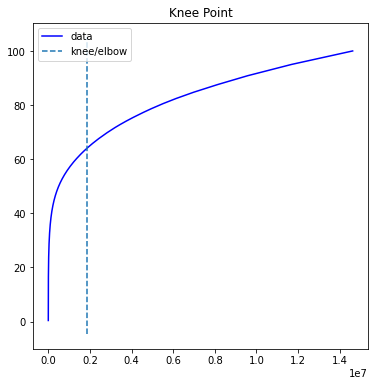

In [39]:
fourgram_kneedle = KneeLocator(x=df_fourgram_select.cumul_ratio.index, y=df_fourgram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
fourgram_kneedle.plot_knee()

In [40]:
knee_point_fourgram = round(fourgram_kneedle.knee_y)

In [41]:
df_fourgram_knee = df_fourgram_select[df_fourgram_select.cumul_ratio <= knee_point_fourgram]
df_fourgram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_fourgram_knee

<ipython-input-41-03ada6cfbf6e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fourgram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)


,fourgram,frequency
0,i do not know,1317934
1,what are you doing,665946
2,i do not want,310217
3,what s going on,298508
4,what do you mean,278296
...,...,...
1844830,surgically grafted to his,25
1844831,whatever snow does in,25
1844832,was plain to see,25
1844833,on that survival course,25


In [42]:
df_fourgram_select2 = df_fourgram_select.iloc[fourgram_select_start:fourgram_select_end,]
df_fourgram_select2

,fourgram,frequency,ratio,cumul_ratio
0,i do not know,1317934,0.371576,0.371576
1,what are you doing,665946,0.187755,0.559331
2,i do not want,310217,0.087462,0.646793
3,what s going on,298508,0.084161,0.730953
4,what do you mean,278296,0.078462,0.809416
...,...,...,...,...
9995,you can come in,2143,0.000604,20.055977
9996,you realize what you,2143,0.000604,20.056582
9997,so nice to see,2142,0.000604,20.057185
9998,how s that going,2142,0.000604,20.057789


In [44]:
df_fourgram_knee.to_csv("Fourgram_Selected.csv", index=False)
df_fourgram_select2.to_excel(f"Fourgram_Selected_{fourgram_select_end}.xlsx", index=False)

In [45]:
if fivegram_sentence_check:
    df_fivegram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Five_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_fivegram_sent.rename(columns={"five_gram":"fivegram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_fivegram = df_fivegram_sent.loc[:,["fivegram","frequency"]]
else:
    df_fivegram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Fivegram_Merge.csv")  
    df_fivegram = df_fivegram.loc[:,["fivegram","frequency"]]

df_fivegram

,fivegram,frequency
0,başka bir şey var mı,14104
1,bu da ne demek oluyor,10205
2,o kadar da kötü değil,7012
3,sence de öyle değil mi,6305
4,sana bir şey sorabilir miyim,6224
...,...,...
1096831,peder fikret hep şöyle söylerdi,4
1096832,peder fikret intihar etmeye çalışıyor,4
1096833,fikret dolson 12 gün yaşadı,4
1096834,ama fikret diye biri yoktu,4


In [46]:
d_list5  = df_fivegram.iloc[:,0].values.tolist()

resultlist5 = []
manager = multiprocessing.Manager()
resultlist5 = manager.list()

def wordgroup_with_words(d_list5):
    mergelist = []
    try:
        word = d_list5.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist5.append(d_list5)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list5) # string_word liste

result_list5 = list(resultlist5)
df_result5 = pd.DataFrame(result_list5, columns=[0])  # add columns parameter for empty result
df_result5 = df_result5.rename(columns = {0: "fivegram"})
df_merge5 = pd.merge(df_result5, df_fivegram, how="left", on="fivegram")
df_merge_result5 = df_merge5.sort_values(by="frequency", ascending=False)
df_merge_result5.drop_duplicates(inplace=True)
df_merge_result5.reset_index(drop=True, inplace=True)
df_fivegram_select = df_merge_result5
df_fivegram_select

,fivegram,frequency
0,başka bir şey var mı,14104
1,bu da ne demek oluyor,10205
2,o kadar da kötü değil,7012
3,sence de öyle değil mi,6305
4,sana bir şey sorabilir miyim,6224
...,...,...
597091,uzanıp içinden cüzdanımı bulmanı istiyorum,10
597092,bir şey mi dedin anne,10
597093,seninle yarın görüşürüz tamam mı,10
597094,toplandı ve hepsi de kanla,10


In [47]:
fivegram_frequency = df_fivegram_select.iloc[:,1].sum()

In [48]:
df_fivegram_select["ratio"] = round(((df_fivegram_select.iloc[:,1]/fivegram_frequency)*100),7)

In [49]:
df_fivegram_select["cumul_ratio"] = np.cumsum(df_fivegram_select["ratio"])

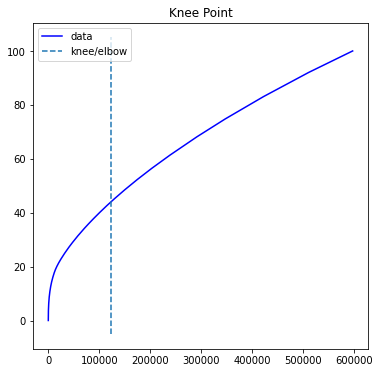

In [50]:
fivegram_kneedle = KneeLocator(x=df_fivegram_select.cumul_ratio.index, y=df_fivegram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
fivegram_kneedle.plot_knee()

In [51]:
knee_point_fivegram = round(fivegram_kneedle.knee_y)

In [52]:
df_fivegram_knee = df_fivegram_select[df_fivegram_select.cumul_ratio <= knee_point_fivegram]
df_fivegram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_fivegram_knee

/home/kurubal/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,fivegram,frequency
0,başka bir şey var mı,14104
1,bu da ne demek oluyor,10205
2,o kadar da kötü değil,7012
3,sence de öyle değil mi,6305
4,sana bir şey sorabilir miyim,6224
...,...,...
122369,ile matrix arasında seçim yapmam,19
122370,hey o iyi bir adam,19
122371,beklemek için nasıl bir yer,19
122372,yani bak normalde beni bilirsin,19


In [53]:
df_fivegram_select2 = df_fivegram_select.iloc[fivegram_select_start:fivegram_select_end,]
df_fivegram_select2

,fivegram,frequency,ratio,cumul_ratio
0,başka bir şey var mı,14104,0.130247,0.130247
1,bu da ne demek oluyor,10205,0.094241,0.224487
2,o kadar da kötü değil,7012,0.064754,0.289241
3,sence de öyle değil mi,6305,0.058225,0.347467
4,sana bir şey sorabilir miyim,6224,0.057477,0.404944
...,...,...,...,...
9995,daha önce hiç karşılaştık mı,66,0.000610,16.841088
9996,size yardım etmekten zevk duyarım,66,0.000610,16.841697
9997,o yüzden bir kez daha,66,0.000610,16.842307
9998,sihirli gücü gerçek bir mucize,66,0.000610,16.842916


In [54]:
df_fivegram_knee.to_csv("Fivegram_Selected.csv", index=False)
df_fivegram_select2.to_excel(f"Fivegram_Selected_{fivegram_select_end}.xlsx", index=False)

In [14]:
if sixgram_sentence_check:
    df_sixgram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Six_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_sixgram_sent.rename(columns={"six_gram":"sixgram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_sixgram = df_sixgram_sent.loc[:,["sixgram","frequency"]]
else:
    df_sixgram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Sixgram_Merge.csv")  
    df_sixgram = df_sixgram.loc[:,["sixgram","frequency"]]

df_sixgram = df_sixgram[df_sixgram["frequency"] > 5]
df_sixgram

,sixgram,frequency
0,sana söylemem gereken bir şey var,3646
1,bir iki üç dört beş altı,2025
2,söylemek istediğin bir şey var mı,1794
3,daha iyi bir fikrin var mı,1792
4,bunun iyi bir fikir olduğunu sanmıyorum,1743
...,...,...
1989975,keskin nişancı çatışması 3 makaranın ortalarında,6
1989976,i̇nsanın bağırsaklarından geçmeden ilahi olana...,6
1989977,üzerinde deney yapmandan ne zaman şikayetim,6
1989978,bana basit bir dilenciden korktuğunu söyleme,6


In [15]:
d_list6  = df_sixgram.iloc[:,0].values.tolist()

resultlist6 = []
manager = multiprocessing.Manager()
resultlist6 = manager.list()

def wordgroup_with_words(d_list6):
    mergelist = []
    try:
        word = d_list6.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist6.append(d_list6)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list6) # string_word liste

result_list6 = list(resultlist6)
df_result6 = pd.DataFrame(result_list6, columns=[0])  # add columns parameter for empty result
df_result6 = df_result6.rename(columns = {0: "sixgram"})
df_merge6 = pd.merge(df_result6, df_sixgram, how="left", on="sixgram")
df_merge_result6 = df_merge6.sort_values(by="frequency", ascending=False)
df_merge_result6.drop_duplicates(inplace=True)
df_merge_result6.reset_index(drop=True, inplace=True)
df_sixgram_select = df_merge_result6
df_sixgram_select

,sixgram,frequency
0,sana söylemem gereken bir şey var,3646
1,bir iki üç dört beş altı,2025
2,söylemek istediğin bir şey var mı,1794
3,daha iyi bir fikrin var mı,1792
4,bunun iyi bir fikir olduğunu sanmıyorum,1743
...,...,...
969006,hayatının yarısından itibaren birbirinizi tanı...,6
969007,hayatta kalma içgüdüsü çocuklarına kadar uzanır,6
969008,bu kullandığınız acayip rus matematiği parmak,6
969009,adı trina beni görünce kollarıma koşar,6


In [16]:
sixgram_frequency = df_sixgram_select.iloc[:,1].sum()

In [17]:
df_sixgram_select["ratio"] = round(((df_sixgram_select.iloc[:,1]/sixgram_frequency)*100),7)

In [18]:
df_sixgram_select["cumul_ratio"] = np.cumsum(df_sixgram_select["ratio"])

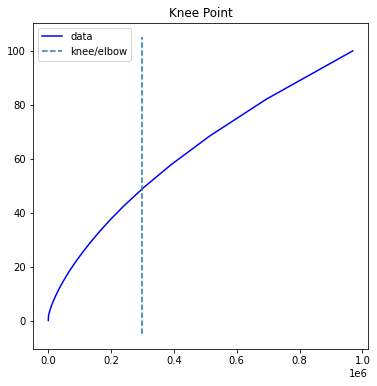

In [19]:
sixgram_kneedle = KneeLocator(x=df_sixgram_select.cumul_ratio.index, y=df_sixgram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
sixgram_kneedle.plot_knee()

In [20]:
knee_point_sixgram = round(sixgram_kneedle.knee_y)

In [21]:
df_sixgram_knee = df_sixgram_select[df_sixgram_select.cumul_ratio <= knee_point_sixgram]
df_sixgram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_sixgram_knee

/home/kurubal/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,sixgram,frequency
0,sana söylemem gereken bir şey var,3646
1,bir iki üç dört beş altı,2025
2,söylemek istediğin bir şey var mı,1794
3,daha iyi bir fikrin var mı,1792
4,bunun iyi bir fikir olduğunu sanmıyorum,1743
...,...,...
300159,bu çocuğun bir süper babaya ihtiyacı,9
300160,sadece yaranın üzerine baskı uygulamaya çalıştım,9
300161,tamam bir iki hafta içinde uğra,9
300162,bana şükran gününde ananas toplama sözü,9


In [22]:
df_sixgram_select2 = df_sixgram_select.iloc[sixgram_select_start:sixgram_select_end,]
df_sixgram_select2

,sixgram,frequency,ratio,cumul_ratio
0,sana söylemem gereken bir şey var,3646,0.039585,0.039585
1,bir iki üç dört beş altı,2025,0.021986,0.061571
2,söylemek istediğin bir şey var mı,1794,0.019478,0.081048
3,daha iyi bir fikrin var mı,1792,0.019456,0.100504
4,bunun iyi bir fikir olduğunu sanmıyorum,1743,0.018924,0.119428
...,...,...,...,...
9995,de girse dışarıda da olsa o,29,0.000315,5.453947
9996,adam gibi bir şey bile yok,29,0.000315,5.454262
9997,gecenin bu saatinde burada ne arıyorsun,29,0.000315,5.454577
9998,hemen şimdi geri dön demiyorum ama,29,0.000315,5.454892


In [23]:
df_sixgram_knee.to_csv("Sixgram_Selected.csv", index=False)
df_sixgram_select2.to_excel(f"Sixgram_Selected_{sixgram_select_end}.xlsx", index=False)

In [24]:
if sevengram_sentence_check:
    df_sevengram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Seven_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_sevengram_sent.rename(columns={"seven_gram":"sevengram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_sevengram = df_sevengram_sent.loc[:,["sevengram","frequency"]]
else:
    df_sevengram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Sevengram_Merge.csv")  
    df_sevengram = df_sevengram.loc[:,["sevengram","frequency"]]

df_sevengram = df_sevengram[df_sevengram["frequency"] > 5]
df_sevengram

,sevengram,frequency
0,bir iki üç dört beş altı yedi,1455
1,iki üç dört beş altı yedi sekiz,1080
2,bana söylemek istediğin bir şey var mı,752
3,yedi altı beş dört üç iki bir,596
4,sekiz yedi altı beş dört üç iki,551
...,...,...
1100889,ama sanırım bu rolü bir başkasına vereceğiz,6
1100890,bakalım başka bir şekilde ağzından bir isim,6
1100891,asıl önemli olan teddy işin sonunda sonunda,6
1100892,ara arabasını kulübünü ara ama onu bulman,6


In [25]:
d_list7  = df_sevengram.iloc[:,0].values.tolist()

resultlist7 = []
manager = multiprocessing.Manager()
resultlist7 = manager.list()

def wordgroup_with_words(d_list7):
    mergelist = []
    try:
        word = d_list7.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist7.append(d_list7)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list7) # string_word liste

result_list7 = list(resultlist7)
df_result7 = pd.DataFrame(result_list7, columns=[0])  # add columns parameter for empty result
df_result7 = df_result7.rename(columns = {0: "sevengram"})
df_merge7 = pd.merge(df_result7, df_sevengram, how="left", on="sevengram")
df_merge_result7 = df_merge7.sort_values(by="frequency", ascending=False)
df_merge_result7.drop_duplicates(inplace=True)
df_merge_result7.reset_index(drop=True, inplace=True)
df_sevengram_select = df_merge_result7
df_sevengram_select

,sevengram,frequency
0,bir iki üç dört beş altı yedi,1455
1,iki üç dört beş altı yedi sekiz,1080
2,bana söylemek istediğin bir şey var mı,752
3,yedi altı beş dört üç iki bir,596
4,sekiz yedi altı beş dört üç iki,551
...,...,...
471595,hemen bir işe ihtiyacım var tamam mı,6
471596,yükseklerde ki kulenin tepesinde boş boş salla...,6
471597,orada olup olmadığını ya da gelmesini engelley...,6
471598,bir şey söylemeye ya da beni uyarmaya,6


In [26]:
sevengram_frequency = df_sevengram_select.iloc[:,1].sum()

In [27]:
df_sevengram_select["ratio"] = round(((df_sevengram_select.iloc[:,1]/sevengram_frequency)*100),7)

In [28]:
df_sevengram_select["cumul_ratio"] = np.cumsum(df_sevengram_select["ratio"])

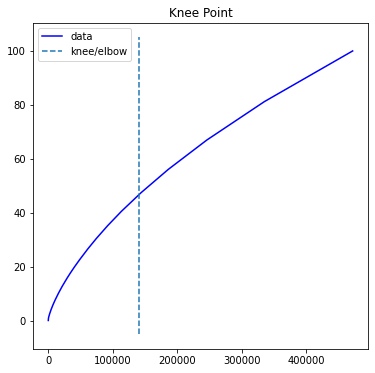

In [29]:
sevengram_kneedle = KneeLocator(x=df_sevengram_select.cumul_ratio.index, y=df_sevengram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
sevengram_kneedle.plot_knee()

In [30]:
knee_point_sevengram = round(sevengram_kneedle.knee_y)

In [31]:
df_sevengram_knee = df_sevengram_select[df_sevengram_select.cumul_ratio <= knee_point_sevengram]
df_sevengram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_sevengram_knee

/home/kurubal/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,sevengram,frequency
0,bir iki üç dört beş altı yedi,1455
1,iki üç dört beş altı yedi sekiz,1080
2,bana söylemek istediğin bir şey var mı,752
3,yedi altı beş dört üç iki bir,596
4,sekiz yedi altı beş dört üç iki,551
...,...,...
141654,akşam üçüncü ve muhtemelen son olarak yerde,9
141655,herifi durdurmak için sadece bir saat kırk,9
141656,görücü usulü evlenmek daha çok işe yarıyor,9
141657,konuda çok yanlış olduğundan kesinlikle eminim...,9


In [32]:
df_sevengram_select2 = df_sevengram_select.iloc[sevengram_select_start:sevengram_select_end,]
df_sevengram_select2

,sevengram,frequency,ratio,cumul_ratio
0,bir iki üç dört beş altı yedi,1455,0.033321,0.033321
1,iki üç dört beş altı yedi sekiz,1080,0.024733,0.058055
2,bana söylemek istediğin bir şey var mı,752,0.017222,0.075277
3,yedi altı beş dört üç iki bir,596,0.013649,0.088926
4,sekiz yedi altı beş dört üç iki,551,0.012619,0.101544
...,...,...,...,...
9995,parkta piknik yapıp kocaman bir turta yedim,23,0.000527,7.322602
9996,sana büyük bir taktik avantaj ve olanak,23,0.000527,7.323128
9997,amcanız önemli bir mesaj verecek sakın uyuşturucu,23,0.000527,7.323655
9998,daha yeni tanıştık ama niye gelip bizimle,23,0.000527,7.324182


In [33]:
df_sevengram_knee.to_csv("Sevengram_Selected.csv", index=False)
df_sevengram_select2.to_excel(f"Sevengram_Selected_{sevengram_select_end}.xlsx", index=False)

In [34]:
if eightgram_sentence_check:
    df_eightgram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Eight_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_eightgram_sent.rename(columns={"eight_gram":"eightgram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_eightgram = df_eightgram_sent.loc[:,["eightgram","frequency"]]
else:
    df_eightgram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Eightgram_Merge.csv")  
    df_eightgram = df_eightgram.loc[:,["eightgram","frequency"]]

df_eightgram = df_eightgram[df_eightgram["frequency"] >= 5]
df_eightgram

,eightgram,frequency
0,bir iki üç dört beş altı yedi sekiz,1060
1,hem de tek bir başıma sinirlenmişim var mı,538
2,de tek bir başıma sinirlenmişim var mı kaşınan,538
3,dokuz sekiz yedi altı beş dört üç iki,513
4,sekiz yedi altı beş dört üç iki bir,497
...,...,...
838905,dokunur dokunmaz onu anladım o da beni anladı,5
838906,bazı şeyler söyledim ve bazı şeyler yaptım üzg...,5
838907,ancak bugün bir suçlu gençler çetesi tarafında...,5
838908,sana pachmayr kabzalı beretta 92f kullanmanı ö...,5


In [35]:
d_list8  = df_eightgram.iloc[:,0].values.tolist()

resultlist8 = []
manager = multiprocessing.Manager()
resultlist8 = manager.list()

def wordgroup_with_words(d_list8):
    mergelist = []
    try:
        word = d_list8.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist8.append(d_list8)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list8) # string_word liste

result_list8 = list(resultlist8)
df_result8 = pd.DataFrame(result_list8, columns=[0])  # add columns parameter for empty result
df_result8 = df_result8.rename(columns = {0: "eightgram"})
df_merge8 = pd.merge(df_result8, df_eightgram, how="left", on="eightgram")
df_merge_result8 = df_merge8.sort_values(by="frequency", ascending=False)
df_merge_result8.drop_duplicates(inplace=True)
df_merge_result8.reset_index(drop=True, inplace=True)
df_eightgram_select = df_merge_result8
df_eightgram_select

,eightgram,frequency
0,bir iki üç dört beş altı yedi sekiz,1060
1,dokuz sekiz yedi altı beş dört üç iki,513
2,sekiz yedi altı beş dört üç iki bir,497
3,iki üç dört beş altı yedi sekiz dokuz,411
4,üç dört beş altı yedi sekiz dokuz on,329
...,...,...
318763,dürüst olmam gerekirse genç adam şu anda pek,5
318764,bağlılık ailemde uzun süredir var olan bir gel...,5
318765,aramaya devam etmeden önce bir sorum daha var,5
318766,kısa menzilli saldırı için yapıldı bu kadar bü...,5


In [36]:
eightgram_frequency = df_eightgram_select.iloc[:,1].sum()

In [37]:
df_eightgram_select["ratio"] = round(((df_eightgram_select.iloc[:,1]/eightgram_frequency)*100),7)

In [38]:
df_eightgram_select["cumul_ratio"] = np.cumsum(df_eightgram_select["ratio"])

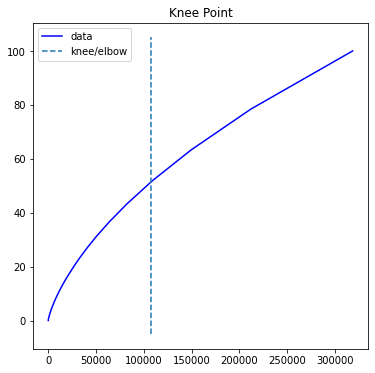

In [39]:
eightgram_kneedle = KneeLocator(x=df_eightgram_select.cumul_ratio.index, y=df_eightgram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
eightgram_kneedle.plot_knee()

In [40]:
knee_point_eightgram = round(eightgram_kneedle.knee_y)

In [41]:
df_eightgram_knee = df_eightgram_select[df_eightgram_select.cumul_ratio <= knee_point_eightgram]
df_eightgram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_eightgram_knee

/home/kurubal/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,eightgram,frequency
0,bir iki üç dört beş altı yedi sekiz,1060
1,dokuz sekiz yedi altı beş dört üç iki,513
2,sekiz yedi altı beş dört üç iki bir,497
3,iki üç dört beş altı yedi sekiz dokuz,411
4,üç dört beş altı yedi sekiz dokuz on,329
...,...,...
109469,ve bunu her yaptığında takım arkadaşlarından b...,7
109470,gizli gizli dolaşan genç bir haham imajı canla...,7
109471,için tek yol kahrolası paramı bana geri vermen,7
109472,teşkilatın görev kapsamında olsa bile görev se...,7


In [42]:
df_eightgram_select2 = df_eightgram_select.iloc[eightgram_select_start:eightgram_select_end,]
df_eightgram_select2

,eightgram,frequency,ratio,cumul_ratio
0,bir iki üç dört beş altı yedi sekiz,1060,0.042888,0.042888
1,dokuz sekiz yedi altı beş dört üç iki,513,0.020756,0.063644
2,sekiz yedi altı beş dört üç iki bir,497,0.020109,0.083753
3,iki üç dört beş altı yedi sekiz dokuz,411,0.016629,0.100382
4,üç dört beş altı yedi sekiz dokuz on,329,0.013311,0.113693
...,...,...,...,...
9995,babamın önünde diz çöktü babam da onun boğazını,18,0.000728,9.875479
9996,şişe neredeyse doldu ve ben hala devam ediyorum,18,0.000728,9.876208
9997,yazık ki bu dava için ceza avukatı gerekiyor,18,0.000728,9.876936
9998,parmak izleri yarasa adam bize her şeyi verdi,18,0.000728,9.877664


In [43]:
df_eightgram_knee.to_csv("Eightgram_Selected.csv", index=False)
df_eightgram_select2.to_excel(f"Eightgram_Selected_{eightgram_select_end}.xlsx", index=False)

In [44]:
if ninegram_sentence_check:
    df_ninegram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Nine_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_ninegram_sent.rename(columns={"nine_gram":"ninegram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_ninegram = df_ninegram_sent.loc[:,["ninegram","frequency"]]
else:
    df_ninegram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Ninegram_Merge.csv")  
    df_ninegram = df_ninegram.loc[:,["ninegram","frequency"]]

df_ninegram = df_ninegram[df_ninegram["frequency"] >= 5]
df_ninegram

,ninegram,frequency
0,hem de tek bir başıma sinirlenmişim var mı kaş...,538
1,dokuz sekiz yedi altı beş dört üç iki bir,463
2,bir iki üç dört beş altı yedi sekiz dokuz,405
3,ototrofların ağzı sulanmaya başladı i̇lk insan...,321
4,iki üç dört beş altı yedi sekiz dokuz on,287
...,...,...
359630,eğer yapabileceğini düşündüğün bir şey görüyor...,5
359631,i̇tiraf etmeliyim ki çadırı tekrar dikme süren...,5
359632,çok bir şey yok ama bir şeyler olduğu kesin,5
359633,buraya davet ediyorum ama siz bizi dolandırmay...,5


In [45]:
d_list9  = df_ninegram.iloc[:,0].values.tolist()

resultlist9 = []
manager = multiprocessing.Manager()
resultlist9 = manager.list()

def wordgroup_with_words(d_list9):
    mergelist = []
    try:
        word = d_list9.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist9.append(d_list9)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list9) # string_word liste

result_list9 = list(resultlist9)
df_result9 = pd.DataFrame(result_list9, columns=[0])  # add columns parameter for empty result
df_result9 = df_result9.rename(columns = {0: "ninegram"})
df_merge9 = pd.merge(df_result9, df_ninegram, how="left", on="ninegram")
df_merge_result9 = df_merge9.sort_values(by="frequency", ascending=False)
df_merge_result9.drop_duplicates(inplace=True)
df_merge_result9.reset_index(drop=True, inplace=True)
df_ninegram_select = df_merge_result9
df_ninegram_select

,ninegram,frequency
0,dokuz sekiz yedi altı beş dört üç iki bir,463
1,bir iki üç dört beş altı yedi sekiz dokuz,405
2,iki üç dört beş altı yedi sekiz dokuz on,287
3,on dokuz sekiz yedi altı beş dört üç iki,277
4,ve sen herkesin seni tanıdığı o yerde olmak is...,134
...,...,...
120720,bu yüzden mi onun başını belaya sokup evlenmey...,5
120721,hala hayattasın çünkü silahın yok ve seni öldü...,5
120722,duş ya da banyo gibi bir alan inşa edildi,5
120723,öyle bir kadınsın ki kendini her yerde belli e...,5


In [46]:
ninegram_frequency = df_ninegram_select.iloc[:,1].sum()

In [47]:
df_ninegram_select["ratio"] = round(((df_ninegram_select.iloc[:,1]/ninegram_frequency)*100),7)

In [48]:
df_ninegram_select["cumul_ratio"] = np.cumsum(df_ninegram_select["ratio"])

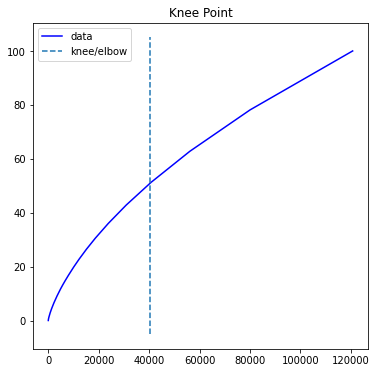

In [49]:
ninegram_kneedle = KneeLocator(x=df_ninegram_select.cumul_ratio.index, y=df_ninegram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
ninegram_kneedle.plot_knee()

In [50]:
knee_point_ninegram = round(ninegram_kneedle.knee_y)

In [51]:
df_ninegram_knee = df_ninegram_select[df_ninegram_select.cumul_ratio <= knee_point_ninegram]
df_ninegram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_ninegram_knee

/home/kurubal/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,ninegram,frequency
0,dokuz sekiz yedi altı beş dört üç iki bir,463
1,bir iki üç dört beş altı yedi sekiz dokuz,405
2,iki üç dört beş altı yedi sekiz dokuz on,287
3,on dokuz sekiz yedi altı beş dört üç iki,277
4,ve sen herkesin seni tanıdığı o yerde olmak is...,134
...,...,...
40393,artık sana kan nakli yapacak doktor hoffman da...,7
40394,senin ülken için potansiyel terörist teröristi...,7
40395,sabah dokuz gibi geçerken uğrarım bu yüzden ön...,7
40396,herkes benim iyi adam olduğuma inanmakta bu ka...,7


In [52]:
df_ninegram_select2 = df_ninegram_select.iloc[ninegram_select_start:ninegram_select_end,]
df_ninegram_select2

,ninegram,frequency,ratio,cumul_ratio
0,dokuz sekiz yedi altı beş dört üç iki bir,463,0.049747,0.049747
1,bir iki üç dört beş altı yedi sekiz dokuz,405,0.043515,0.093262
2,iki üç dört beş altı yedi sekiz dokuz on,287,0.030837,0.124098
3,on dokuz sekiz yedi altı beş dört üç iki,277,0.029762,0.153861
4,ve sen herkesin seni tanıdığı o yerde olmak is...,134,0.014398,0.168258
...,...,...,...,...
9995,clarence bazen eğer o gün ölseydim ne yapardın...,13,0.001397,19.762071
9996,üstelik bunu yalnız başıma değil bir çocukla b...,13,0.001397,19.763468
9997,kum kaya kaktüs ve mavi gökten başka hiçbir şey,13,0.001397,19.764865
9998,fbi programına virüs koyup programı iki yıl ge...,13,0.001397,19.766261


In [53]:
df_ninegram_knee.to_csv("Ninegram_Selected.csv", index=False)
df_ninegram_select2.to_excel(f"Ninegram_Selected_{ninegram_select_end}.xlsx", index=False)

In [54]:
if tengram_sentence_check:
    df_tengram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Ten_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_tengram_sent.rename(columns={"ten_gram":"tengram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_tengram = df_tengram_sent.loc[:,["tengram","frequency"]]
else:
    df_tengram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Tengram_Merge.csv")  
    df_tengram = df_tengram.loc[:,["tengram","frequency"]]

#df_tengram = df_tengram[df_ninegram["frequency"] > 5]
df_tengram

,tengram,frequency
0,bir iki üç dört beş altı yedi sekiz dokuz on,287
1,on dokuz sekiz yedi altı beş dört üç iki bir,251
2,soboi ostatsya dolshe daha uzun süre kendim ol...,242
3,neşeli ruhu bir gün yelken açtı ta denizden sk...,182
4,oyuncu sayaka kız okulunun 3b sınıfının yeni ö...,167
...,...,...
306170,ve ss arkadaşların öldüler ki ben de onları öy...,3
306171,eğer fotoğrafları teslim edersen bu işin sonu ...,3
306172,eğer gemi zamanından önce denize inerse bütün ...,3
306173,demek istediğim bu programı dünyanın herhangi ...,3


In [55]:
d_list10  = df_tengram.iloc[:,0].values.tolist()

resultlist10 = []
manager = multiprocessing.Manager()
resultlist10 = manager.list()

def wordgroup_with_words(d_list10):
    mergelist = []
    try:
        word = d_list10.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist10.append(d_list10)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list10) # string_word liste

result_list10 = list(resultlist10)
df_result10 = pd.DataFrame(result_list10, columns=[0])  # add columns parameter for empty result
df_result10 = df_result10.rename(columns = {0: "tengram"})
df_merge10 = pd.merge(df_result10, df_tengram, how="left", on="tengram")
df_merge_result10 = df_merge10.sort_values(by="frequency", ascending=False)
df_merge_result10.drop_duplicates(inplace=True)
df_merge_result10.reset_index(drop=True, inplace=True)
df_tengram_select = df_merge_result10
df_tengram_select

,tengram,frequency
0,bir iki üç dört beş altı yedi sekiz dokuz on,287
1,on dokuz sekiz yedi altı beş dört üç iki bir,251
2,g i t a r i s y e n,128
3,t o x i c w o r l d,93
4,umutsuzca birinin arkasından koşuyorum daha gü...,76
...,...,...
90288,sekiz yıl boyunca cumartesi geceleri evde otur...,3
90289,çeyrek asır oyunlarında ne olduğuyla ilgili ço...,3
90290,onun hakkında bir şey bilen biriyle konuşursam...,3
90291,hiç doğru yolu mu seçtik diye merak ettiğin ol...,3


In [56]:
tengram_frequency = df_tengram_select.iloc[:,1].sum()

In [57]:
df_tengram_select["ratio"] = round(((df_tengram_select.iloc[:,1]/tengram_frequency)*100),7)

In [58]:
df_tengram_select["cumul_ratio"] = np.cumsum(df_tengram_select["ratio"])

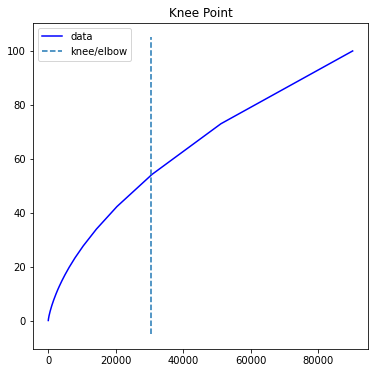

In [59]:
tengram_kneedle = KneeLocator(x=df_tengram_select.cumul_ratio.index, y=df_tengram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
tengram_kneedle.plot_knee()

In [60]:
knee_point_tengram = round(tengram_kneedle.knee_y)

In [61]:
df_tengram_knee = df_tengram_select[df_tengram_select.cumul_ratio <= knee_point_tengram]
df_tengram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_tengram_knee

/home/kurubal/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,tengram,frequency
0,bir iki üç dört beş altı yedi sekiz dokuz on,287
1,on dokuz sekiz yedi altı beş dört üç iki bir,251
2,g i t a r i s y e n,128
3,t o x i c w o r l d,93
4,umutsuzca birinin arkasından koşuyorum daha gü...,76
...,...,...
30518,kendi ülken başkasının ülkesi ya da kendi kişi...,5
30519,son altı ay içinde aynı tarzda bir düzine soyg...,5
30520,benim hikayem birkaç yıl önce yayınlandı kendi...,5
30521,aslında ben bunun pek de kötü bir fikir olmadı...,5


In [62]:
df_tengram_select2 = df_tengram_select.iloc[tengram_select_start:tengram_select_end,]
df_tengram_select2

,tengram,frequency,ratio,cumul_ratio
0,bir iki üç dört beş altı yedi sekiz dokuz on,287,0.066081,0.066081
1,on dokuz sekiz yedi altı beş dört üç iki bir,251,0.057792,0.123873
2,g i t a r i s y e n,128,0.029472,0.153345
3,t o x i c w o r l d,93,0.021413,0.174758
4,umutsuzca birinin arkasından koşuyorum daha gü...,76,0.017499,0.192257
...,...,...,...,...
9995,gerçekten çok akıllı mısın yoksa aşırı salak m...,8,0.001842,27.109629
9996,siz adamı bize teslim ettiniz ve size bir teşe...,8,0.001842,27.111471
9997,belki de kendine güvendiği için herkes onun iy...,8,0.001842,27.113313
9998,bak burada kimse bu konuyla ilgili benim kadar...,8,0.001842,27.115155


In [63]:
df_tengram_knee.to_csv("Tengram_Selected.csv", index=False)
df_tengram_select2.to_excel(f"Tengram_Selected_{tengram_select_end}.xlsx", index=False)

#### Copy Move And Delete

In [45]:
output_file = glob.glob(f"*_Selected*")
output_file

['Twogram_Selected.csv',
 'Twogram_Selected_10000.xlsx',
 'Threegram_Selected.csv',
 'Threegram_Selected_10000.xlsx',
 'Fourgram_Selected.csv',
 'Fourgram_Selected_10000.xlsx']

In [46]:
for l in output_file:
    source = l # source directory
    destination = path
    shutil.copy2(source, destination)

In [47]:
for j in output_file:
    try:
        os.remove(j)
    except:
        pass